# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Оглавление<a class="anchor" id="TOC"></a>
***

* **[1. Подготовка данных](#1)**
    - [1) Объявим класс Explorer и наполним его методами](#1_1)
    - [2) Импортируем библиотеки](#1_2)
    - [3) Прочитаем данные](#1_3)
    - [4) Выведем первые пять строк каждой из таблиц, общую информацию](#1_4)
    - [5) Выведем общую статистку по датасету и наличие дубликатов](#1_5)
    - [6) Исправим регистр с помощью строкового метода str.lower()](#1_6)
    - [7) Ознакомимся с признаками](#1_7)
    - [8) Заполним пропуски в столбце tenure](#1_8)
    - [9) Разделим данные на выборки](#1_9)
    - [Вывод](#1_conclusion)
* **[2. Исследование задачи](#2)**
    - [1) Проверим дисбаланс классов в датасете](#2_1)
    - [2) Построим модели без учета дисбаланса](#2_2)    
        - [DecisionTreeClassifier](#2_dtc)
        - [RandomForestClassifier](#2_rfc)
    - [Вывод](#2_conclusion)
* **[3. Борьба с дисбалансом](#3)**
    - [1) Придадим объектам редкого класса больший вес](#3_1)
        - [DecisionTreeClassifier](#3_dtc)
        - [RandomForestClassifier](#3_rfc)
    - [2) Увеличение выборки](#3_2)
        - [DecisionTreeClassifier](#3_2_dtc)
        - [RandomForestClassifier](#3_2_rfc)
    - [3) Уменьшение выборки](#3_3)    
        - [DecisionTreeClassifier](#3_3_dtc)
        - [RandomForestClassifier](#3_3_rfc)   
    - [4) Увеличим выборку с помощью алгоритма SMOTE (Synthetic Minority Over-sampling Technique)](#3_4)
        - [DecisionTreeClassifier](#3_4_dtc)
        - [RandomForestClassifier](#3_4_rfc)
    - [5) Выведем таблицу построенных моделей с результатами на валидационных данных](#3_5)
    - [Вывод](#3_conclusion)
* **[4. Тестирование модели](#4)**
    - [1) Посчитаем для каждой из моделей F1 Score на тестовых данных и дополним таблицу](#4_1)
    - [2) Рассмотрим подробнее модель с лучшим F1 Score на тестовых данных](#4_2)
    - [Вывод](#4_conclusion)

# 1. Подготовка данных<a class="anchor" id="1"></a>
***

## 1) Объявляем класс Explorer и наполняем его методами<a class="anchor" id="1_1"></a>

In [1]:
class Explorer:
    
    def histogram(self, data, n_bins, range_start, range_end, grid, cumulative=False, x_label = "", y_label = "", title = ""):
        """
        data - датасет
        n_bins - количество корзин
        range_start - минимальный икс для корзины
        range_end - максимальный икс для корзины
        grid - рисовать сетку или нет (False / True)
        
        
        histogram(data, n_bins, range_start, range_end, grid, x_label = "", y_label = "", title = "")
        
        Пример:
        histogram(df, 100, 0, 150, True, 'Количество иксов', 'Количество игриков', 'Заголовок')
        """
        # Создаем объект - график
        _, ax = plt.subplots()

        # Задаем параметры
        ax.hist(data, bins = n_bins, range = (range_start, range_end), cumulative = cumulative, color = '#4169E1')

        # Добавляем сетку
        if grid == True:
            ax.grid(color='grey', linestyle='-', linewidth=0.5)
        else:
            pass

        # Добавляем медиану, среднее и квартили
        ax.axvline(data.median(),linestyle = '--', color = '#FF1493', label = 'median')
        ax.axvline(data.mean(),linestyle = '--', color = 'orange', label = 'mean')
        ax.axvline(data.quantile(0.1),linestyle = '--', color = 'yellow', label = '1%')
        ax.axvline(data.quantile(0.99),linestyle = '--', color = 'yellow', label = '99%')
        ax.legend()
        ax.set_ylabel(y_label)
        ax.set_xlabel(x_label)
        ax.set_title(title)
        
    def scatterplot(self, x_data, y_data, x_label="", y_label="", title="", color = "r", yscale_log=False, figsize = (8, 6)):

        # Создаем объект - график
        _, ax = plt.subplots(figsize = (8, 6))

        # Задаем параметры для графика, определяем размер (s), цвет и прозрачность точек на графике
        ax.scatter(x_data, y_data, s = 10, color = color, alpha = 0.75)

        if yscale_log == True:
            ax.set_yscale('log')

        # Создаем описание осей и заголовок для графика
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        
    def overlaid_histogram(self, data1, data2, n_bins = 0, data1_name="", data1_color="#539caf", data2_name="", data2_color="#7663b0", x_label="", y_label="", title=""):
        # Устанавливаем границы для корзин так чтобы оба распределения на графике были соотносимы
        max_nbins = 10
        data_range = [min(min(data1), min(data2)), max(max(data1), max(data2))]
        binwidth = (data_range[1] - data_range[0]) / max_nbins


        if n_bins == 0:
            bins = np.arange(data_range[0], data_range[1] + binwidth, binwidth)
        else: 
            bins = n_bins

        # Рисуем график
        _, ax = plt.subplots(figsize=(10,8))
        ax.hist(data1, bins = bins, color = data1_color, alpha = 0.65, label = data1_name)
        ax.hist(data2, bins = bins, color = data2_color, alpha = 0.65, label = data2_name)
        
        ax.axvline(data1.mean(),linestyle = '--', color = 'lime', label = 'mean for data 1')
                
        ax.axvline(data2.mean(),linestyle = '--', color = 'coral', label = 'mean for data 2')
                
        ax.set_ylabel(y_label)
        ax.set_xlabel(x_label)
        ax.set_title(title)
        ax.legend(loc = 'best')
        
    def corr_diagram(self, x):
        plt.figure(figsize=(12,10), dpi= 80)
        sns.heatmap(x.corr(), xticklabels=x.corr().columns, yticklabels=x.corr().columns, cmap='RdYlGn', center=0, annot=True)
        plt.title('Диаграмма корреляции', fontsize=22)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()
        
        
    def highlight_max(self, data, color='#00FF00'):
        '''
        highlight the maximum in a Series or DataFrame
        '''
        attr = 'background-color: {}'.format(color)
        #remove % and cast to float
        data = data.replace('%','', regex=True).astype(float)
        data[data == 1] = None
        if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
            is_max = (data == data.abs().max()) & (data !=1) 
            return [attr if v else '' for v in is_max]
        else:  # from .apply(axis=None)
            is_max = (data == data.abs().max()) & (data !=1) 
            return pd.DataFrame(np.where(is_max, attr, ''),
                                index=data.index, columns=data.columns)
    
    
    def highlight_sorted_corr(self, data, color='#00FF00'):
        '''
        highlight the maximum in a Series or DataFrame
        '''
        attr = 'background-color: {}'.format(color)
        #remove % and cast to float
        data = data.replace('%','', regex=True).astype(float)
        data[data == 1] = None
        if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
            is_max = (data > 0.1) & (data !=1) 
            return [attr if v else '' for v in is_max]
        else:  # from .apply(axis=None)
            is_max = (data == data.abs().max()) & (data !=1) 
            return pd.DataFrame(np.where(is_max, attr, ''),
                                index=data.index, columns=data.columns)
        
        
    def lineplot(self, x_data, y_data, x_label="", y_label="", title=""):
        # Создаем объект - график
        _, ax = plt.subplots(figsize=(8, 6))

        # Задаем параметры для линии: ширину (lw), цвет и прозрачность (alpha)
        ax.plot(x_data, y_data, lw = 2, color = '#539caf', alpha = 1)

        # Даем имена осям и заголовок для графика
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        
        
    def double_lineplot(self, x_data_1, y_data_1, x_data_2, y_data_2, x_label="", y_label="", title="", label_one="", label_two=""):
        # Создаем объект - график
        _, ax = plt.subplots(figsize=(8, 6))

        # Задаем параметры для линии: ширину (lw), цвет и прозрачность (alpha)
        ax.plot(x_data_1, y_data_1, lw = 2, color = '#6400e4', alpha = 1, label = label_one)
        ax.plot(x_data_2, y_data_2, lw = 2, color = '#ffc740', alpha = 1, label = label_two)

        # Даем имена осям и заголовок для графика
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.legend(loc = 'best')
    
        
    def hexbin(self, data, x, y):
        data.plot(x = x, y = y, kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True)
        
        
    def bar_plotter(self, data):
        data.plot.bar(rot=0, figsize = (16, 5))
        
        
    def categorical_counter_plot(self, data, column, x = '', y = ''):
        if x == '' or y == '':
            plt.rcParams["figure.figsize"] = (15, 10)
        else:
            plt.rcParams["figure.figsize"] = (x, y)
        
        order = data[column].value_counts().index
            
        ax = sns.countplot(data[column], order = order)
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=11)
        
        plt.xticks(rotation=90)
        
       
    def sns_scatterplot(self, data, x="", y="", hue="", size="", palette=""):
        
        sns.set(style="whitegrid")

        f, ax = plt.subplots(figsize=(15, 10))
        
        if palette == True:
            sns.scatterplot(ax = ax, x=x, y=y, palette="ch:r=-.2,d=.3_r", 
                            hue=hue, size=size, sizes=(1, 200), linewidth=0, data=data)
        else:
            sns.scatterplot(ax = ax, x=x, y=y,
                            hue=hue, size=size, 
                            sizes=(1, 200), linewidth=0, data=data)
            
    def sns_catplot(self, data, x="", y="", hue=""):
        sns.set(style='whitegrid')
        
        sns.catplot(x=x, y=y, hue=hue, kind='bar', errwidth=0, 
            data=data, height=5, aspect=3)
        
    def sns_factorplot(self, data, x='', hue=''):
        sns.axes_style('white')
        g = sns.factorplot("exited", data=df, aspect=1, kind='count',
                       hue='hascrcard')
        
    def squared_ratio(self, df, grouper, title=''):
        df = df.groupby(grouper).size().reset_index(name='counts')
        labels = df.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
        sizes = df['counts'].values.tolist()
        colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

        plt.figure(figsize=(10,6), dpi= 80)
        squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

        plt.title(title)
        plt.axis('off')
        plt.show()
        
        
    def sorted_corr(self, data, attr):
        correlated = pd.DataFrame(data.corr()[attr].sort_values(ascending = False))
        return correlated    
    
    
    def transformer(self, data, name, grouper, func):
        """
        data - датасет
        name - столбец в котором меняем значения
        grouper - столбец по которому группируем
        func - пременяемая функция mean, median и т.д.
        """
        name = name
        data.loc[data[name].isnull(), name] = data.groupby(grouper)[name].transform(func)
        
    def pr_curve(self, model, features_valid, target_valid):
        probabilities_valid = model.predict_proba(features_valid)
        precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

        plt.figure(figsize=(6, 6))
        plt.step(recall, precision, where='post')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('Кривая Precision-Recall')
        plt.show()
        
    def roc_curve(self, model, features_valid, target_valid):
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        
        fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
        
        plt.figure()
        plt.plot(fpr, tpr)
        
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlim(0,1)
        plt.ylim(0,1)
        
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
        plt.title('ROC-кривая')
        
        plt.show()
        
    
    def metrics_plot(self, model, features_valid, target_valid):
        probabilities_valid = model.predict_proba(features_valid)
        precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])
        fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid[:, 1])
            
        fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        
        #fig, ax = plt.subplots(ncols=3)
        #fig.subplots_adjust(hspace=0.4, wspace=0.4)

        sns.lineplot(recall, precision, drawstyle='steps-post', ax=ax[0])
        ax[0].set_xlabel('Recall')
        ax[0].set_ylabel('Precision')
        ax[0].set_ylim([0.0, 1.05])
        ax[0].set_xlim([0.0, 1.0])
        ax[0].set_title('Кривая Precision-Recall')
        
        sns.lineplot(fpr, tpr, ax=ax[1])
        ax[1].plot([0, 1], [0, 1], linestyle='--')
        ax[1].set_xlim(0,1)
        ax[1].set_ylim(0,1)
        ax[1].set_xlabel('False Positive Rate')
        ax[1].set_ylabel('True Positive Rate')
        ax[1].set_title('ROC-кривая')
        
 
    def auc_roc(self, model, features_valid, target_valid):
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        
        return auc_roc
            
    def upsample(self, features, target, repeat):
        features_zeros = features[target == 0]
        features_ones = features[target == 1]
        target_zeros = target[target == 0]
        target_ones = target[target == 1]

        features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
        target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

        features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=42)
        
        return features_upsampled, target_upsampled
        
        
    def downsample(self, features, target, fraction):
        features_zeros = features[target == 0]
        features_ones = features[target == 1]
        target_zeros = target[target == 0]
        target_ones = target[target == 1]
        
        features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
        target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])
        
        features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=42)
        
        return features_downsampled, target_downsampled
            
        
    class Display(object):
        """Выводит HTML представление нескольких объектов"""
        template = """<div style="float: left; padding: 10px;">
        <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
        </div>"""
        def __init__(self, *args):
            self.args = args

        def _repr_html_(self):
            return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                             for a in self.args)

        def __repr__(self):
            return '\n\n'.join(a + '\n' + repr(eval(a))
                               for a in self.args)

In [2]:
explorer = Explorer()

[В оглавление](#TOC)

## 2) Импортируем библиотеки<a class="anchor" id="1_2"></a>

In [3]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install squarify

Note: you may need to restart the kernel to use updated packages.


In [5]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)

Using TensorFlow backend.


In [6]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import squarify 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

[В оглавление](#TOC)

## 3) Прочитаем данные<a class="anchor" id="1_3"></a>

In [7]:
df = pd.read_csv('Churn.csv')

[В оглавление](#TOC)

## 4) Выведем первые пять строк каждой из таблиц, общую информацию<a class="anchor" id="1_4"></a>

In [8]:
head = df.head(5)
tail = df.tail(5)
sample = df.sample(5)

In [9]:
explorer.Display('head', 'tail', 'sample')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


&#9889; **Вывод:** 

1. В датасете 10 000 строк, есть пропуски  столбце Tenure (909 из 10 000 - 9%).
2. Нет проблем с типами данных.
3. В столбце с балансом есть нули, но на данный момент нет оснований считать, что это пропуски.
4. В столбце Tenure содержаться потенциально странные данные о числе объектов недвижимости - 8 и 10. Необходимо дополнительное исследование.
5. Исходя из описания данных, столбцы RowNumber, CustomerId, Surname - кандидаты на удаления, поскольку нерелевантны по отношению к искомому признаку, не являются универсальными признаками. 

[В оглавление](#TOC)

## 5) Выведем общую статистку по датасету, проверим наличие дубликатов<a class="anchor" id="1_5"></a>

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,9091.0,4.997690e+00,2.894723,0.00,2.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


За исключением наблюдений о недвижимости, странных значений не усматривается. Выведем информацию о категориальных данных:

In [12]:
df.describe(include = ['object']).T

,count,unique,top,freq
Surname,10000,2932,Smith,32
Geography,10000,3,France,5014
Gender,10000,2,Male,5457


### - проверим наличие полных дубликатов

In [13]:
(df.duplicated() == True).sum()

0

Полных дубликатов нет

### - проверим уникальные значения

In [14]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

&#9889; **Вывод:**

1. В датасете представлены данные из трех стран о 10 000 уникальных клиентах. 
2. Чуть больше половины (5014 из 10000) - данные о Французских клиентах. 
3. Ожидаемо, самая популярная фамилия - Смит (32 из 2932 - 1%).
4. В выборке чуть больше половины клиентов - мужчины (5457 из 10 000 - 55 %).
5. Столбцы с наблюдениями о поле клиента (gender), наличии кредитных карт (hascrcard), активности (isactivemember), прекращении договора (exited) содержат бинарные значения (1/0).
6. Полные дубликаты отсутствуют.

[В оглавление](#TOC)

## 6) Исправим регистр с помощью строкового метода str.lower()<a class="anchor" id="1_6"></a>

In [15]:
df.columns = df.columns.str.lower()

[В оглавление](#TOC)

## 7) Ознакомимся c признаками<a class="anchor" id="1_7"></a>

### - выведем сводную таблицу со средними значениями

In [16]:
df_pivot = pd.pivot_table(df, index='exited', values=['age', 'balance', 'creditscore', 'estimatedsalary', 'hascrcard', 'isactivemember', 'numofproducts', 'tenure'], aggfunc='mean')
df_pivot

,age,balance,creditscore,estimatedsalary,hascrcard,isactivemember,numofproducts,tenure
exited,,,,,,,,
0,37.408389,72745.296779,651.853196,99738.391772,0.707146,0.554565,1.544267,5.022247
1,44.837997,91108.539337,645.351497,101465.677531,0.699067,0.360825,1.475209,4.901834


&#9889; **Вывод:**

Исходя из представленных данных, с учетом средних значений признаков, можно сделать следующие выводы: 

1. Средние значения очень близки, модели будет трудно.
2. Средний возраст, баланс, активность - самые оличающиеся признаки: ушедшие клиенты старше, менее активны и держать больше денег на счете.

[В оглавление](#TOC)

### - число продуктов, наличие кредитной карты, активность клиента

Ознакомимся с бинарными признаками

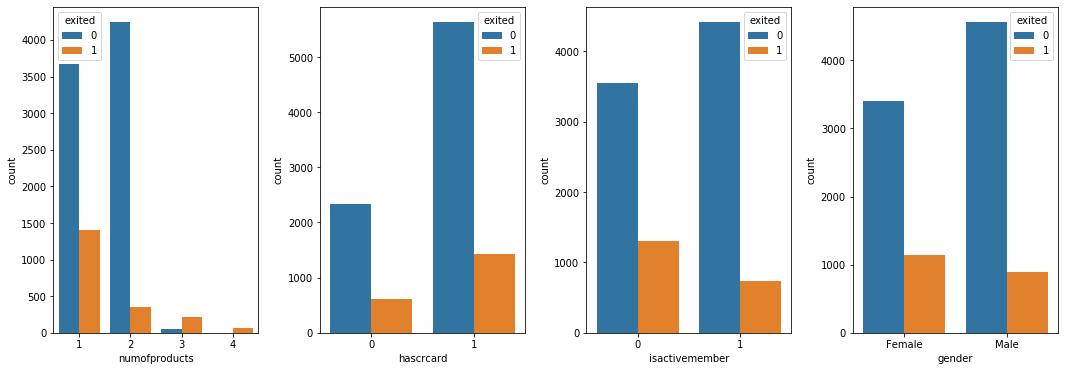

In [17]:
_, ax = plt.subplots(1, 4, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)
sns.countplot(x='numofproducts', hue='exited', data = df, ax= ax[0])
sns.countplot(x='hascrcard', hue='exited', data = df, ax = ax[1])
sns.countplot(x='isactivemember', hue='exited', data = df, ax = ax[2])
sns.countplot(x='gender', hue='exited', data = df, ax = ax[3])

&#9889; **Вывод:**

с осторожностью можно утверждать, что исходя из имеющихся данных: 
1. Число продуктов отрицательно влияет на уход клиента - клиенты с одним продуктом уходят чаще.
2. Наличие кредитной карты положительно влияет на уход клиента - клиенты с кредитной картой уходят чаще.
3. Активность клиента отрицательно влияет на уход - активные клиенты уходят вдвое реже.
4. Принимая во внимание соотношение мужчин и женщин в выборке, грубо, 1 к 1 - женщины чуть чаще уходят, чем мужчины.

[В оглавление](#TOC)

### - возраст

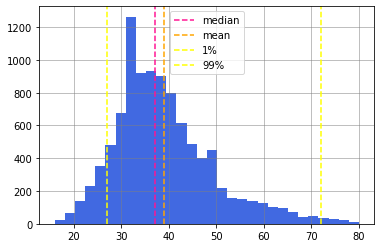

In [18]:
explorer.histogram(df.age, 30, 16, 80, True)

In [19]:
df.age.describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64

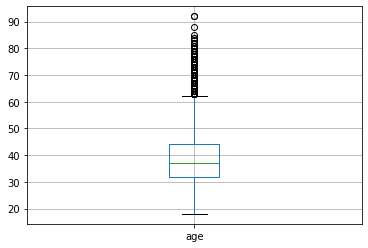

In [20]:
df.boxplot('age')

&#9889; **Вывод:** 

1. В представленном датасете - самому молодому клиенту 18 лет, самому старому - 92 года.
2. Распределение скошено вправо, поэтому среднее выше медианы.
3. Судя по ящику с усами - выбросов много. Выбросы по возрасту должны остаться - они являются частью явления, поскольку возрастных клиентов много и возраст влияет на уход.

[В оглавление](#TOC)

### - предполагаемая зарплата

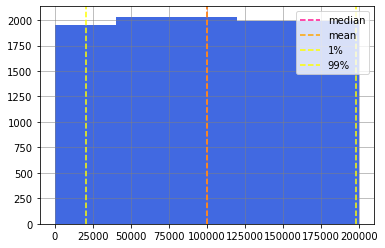

In [21]:
explorer.histogram(df.estimatedsalary, 5, 0, 200000, True)

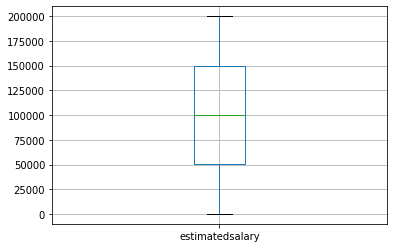

In [22]:
df.boxplot('estimatedsalary')

In [23]:
df.estimatedsalary.describe()

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: estimatedsalary, dtype: float64

&#9889; **Вывод:** 

1. В представленном датасете - нименьшая предполагаемая зарплата 11.58, самая высокая 199992.48.
2. Распределение равномерное - медиана и среднее совпадают.
3. Выбросов нет.

[В оглавление](#TOC)

### - баланс

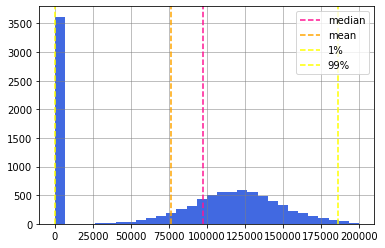

In [24]:
explorer.histogram(df.balance, 30, 0, 200000, True)

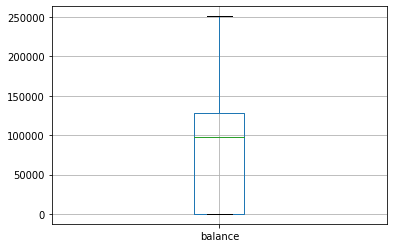

In [25]:
df.boxplot('balance')

In [26]:
df.balance.describe()

count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: balance, dtype: float64

&#9889; **Вывод:** 

1. Пик на нуле.
2. Для банковских балансов - ноль очевидный пик, поэтому странными этм данные не называть. 
3. Пик на нуле тянет среднее влево.

[В оглавление](#TOC)

### - регион

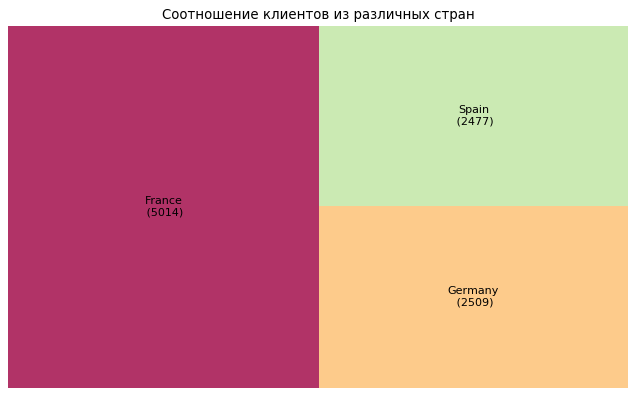

In [27]:
explorer.squared_ratio(df, 'geography', 'Соотношение клиентов из различных стран')

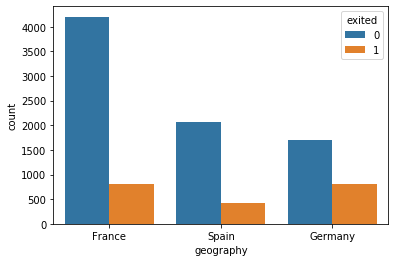

In [28]:
sns.countplot(x='geography', hue='exited', data = df)

In [29]:
df_geography = pd.pivot_table(df, index='geography', values=['age', 'balance', 'creditscore', 'estimatedsalary', 'hascrcard', 'isactivemember', 'numofproducts', 'tenure'], aggfunc='mean')
df_geography

,age,balance,creditscore,estimatedsalary,hascrcard,isactivemember,numofproducts,tenure
geography,,,,,,,,
France,38.511767,62092.636516,649.668329,99899.180814,0.706621,0.516753,1.530913,5.003956
Germany,39.771622,119730.116134,651.453567,101113.435102,0.713830,0.497409,1.519729,4.981247
Spain,38.890997,61818.147763,651.333872,99440.572281,0.694792,0.529673,1.539362,5.001779


&#9889; **Вывод:**

Исходя из представленных данных: 

1. В представленном датасете примерно половина наблюдений о клиентах из Франции - 5014 (50%), четверть из Германии - 2 509 (25%), четверть из Испании -2 477 (25%).
2. За исключением среднего баланса - у клиентов из Германии остаток по счету вдвое больше, чем у клиентов из Испании и Франции - средние показатели очень близки.
3. Клиенты из Германии уходять с частотой сопоставимой с Францией, при том, что общее число клиентов из Германии вдвое меньше.

[В оглавление](#TOC)

### - количество недвижимости

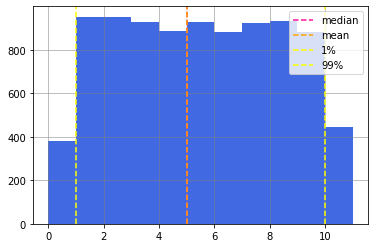

In [30]:
explorer.histogram(df.tenure, 11, 0, 11, True)

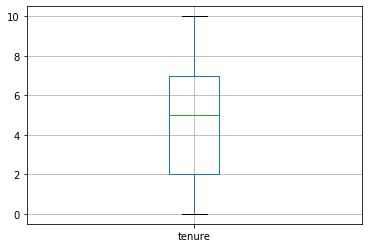

In [31]:
df.boxplot('tenure')

In [32]:
df_tenure = pd.pivot_table(df, index='tenure', values=['rownumber'], aggfunc='count')
df_tenure

,rownumber
tenure,
0.0,382
1.0,952
2.0,950
3.0,928
4.0,885
5.0,927
6.0,881
7.0,925
8.0,933


&#9889; **Вывод:**

1. Столбец с наблюдениями о недвижимости кажутся странными из-за количества, но наблюдается равномерное распредление, без выбросов.
2. Даже если данные кажуться странными, это не означает, что они неправильные. 
3. В отсутвии возможности уточнить у источника данных, принимая во внимание равномерное распределение - допустимо заменить пропуски (909 из 10000) на среднее.

[В оглавление](#TOC)

### - проверим корреляцию

In [33]:
explorer.sorted_corr(df, 'exited').style.apply(explorer.highlight_sorted_corr)

,exited
exited,1
age,0.285323
balance,0.118533
estimatedsalary,0.0120969
customerid,-0.00624799
hascrcard,-0.00713777
rownumber,-0.0165714
tenure,-0.0167615
creditscore,-0.0270935
numofproducts,-0.0478199


&#9889; **Вывод:**

1. В датасете наблюдается относительно сильная линейная положительная корреляция между уходом, возрастом(0.28) и балансом (0.11), а также отрицательная с показателями активности (-0.15).
2. Принимая во внимание уже сделанные выводы - с осторожностью можно утверждать, что корреляция между уходом и другими признаками носит нелинейный характер.

[В оглавление](#TOC)

## 8) Заполним пропуски в столбце tenure<a class="anchor" id="1_8"></a>

In [34]:
df.tenure.fillna(df.tenure.mean(), inplace=True)

In [35]:
df.tenure.isna().any()

False

&#9889; **Вывод:** заполнили пропуски в столбце с количеством недвижимости средним.

[В оглавление](#TOC)

## 9) Разделим данные на выборки<a class="anchor" id="1_9"></a>

**- выберем параметры**

In [36]:
feature = df.drop(['rownumber', 'customerid', 'exited', 'surname'], axis=1)

In [37]:
feature = pd.get_dummies(feature, drop_first=True)

In [38]:
feature.head(5)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,1,0


In [39]:
feature.corr().T

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
creditscore,1.000000,-0.003965,-0.000059,0.006268,0.012238,-0.005458,0.025651,-0.001384,0.005538,0.004780,-0.002857
age,-0.003965,1.000000,-0.012604,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.046897,-0.001685,-0.027544
tenure,-0.000059,-0.012604,1.000000,-0.007534,0.011409,0.025978,-0.030680,0.010050,-0.003151,0.000772,0.012043
balance,0.006268,0.028308,-0.007534,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.401110,-0.134892,0.012087
numofproducts,0.012238,-0.030680,0.011409,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.010419,0.009039,-0.021859
hascrcard,-0.005458,-0.011721,0.025978,-0.014858,0.003183,1.000000,-0.011866,-0.009933,0.010577,-0.013480,0.005766
isactivemember,0.025651,0.085472,-0.030680,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.020486,0.016732,0.022544
estimatedsalary,-0.001384,-0.007201,0.010050,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.010297,-0.006482,-0.008112
geography_Germany,0.005538,0.046897,-0.003151,0.401110,-0.010419,0.010577,-0.020486,0.010297,1.000000,-0.332084,-0.024628
geography_Spain,0.004780,-0.001685,0.000772,-0.134892,0.009039,-0.013480,0.016732,-0.006482,-0.332084,1.000000,0.016889


**- выберем тагет**

In [40]:
target = df.exited

In [41]:
target.head(5)

0    1
1    0
2    1
3    0
4    0
Name: exited, dtype: int64

**- выделим из датасета обучающую часть - 40 %**

In [42]:
x_train, x_test, y_train, y_test  = train_test_split(feature, target, test_size=0.6,random_state = 42)

**- проверим форму полученных выборок**

In [43]:
x_train.shape, y_train.shape

((4000, 11), (4000,))

In [44]:
x_test.shape, y_test.shape

((6000, 11), (6000,))

**- разделим тестовый датасет на валидационный и тестовый - 30 % и 30% от всего датасета**

In [45]:
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

**- проверим форму полученных выборок**

In [46]:
x_train.shape, y_train.shape

((4000, 11), (4000,))

In [47]:
x_valid.shape, y_valid.shape

((3000, 11), (3000,))

In [48]:
x_test.shape, y_test.shape

((3000, 11), (3000,))

&#9889; **Вывод:** разделили выбрку на признаки и целевой признак, а затем раздили на обучающую (0.4), валидационную (0.3) и тестовую (0.3) выборки. Предположительно, такое разделение позволит избежать переобучения.

[В оглавление](#TOC)

## Вывод<a class="anchor" id="1_conclusion"></a>

Исходя из представленных данных, можно сделать следующие выводы:
1.	В датасете представлены данные из трех стран о 10 000 уникальных клиентах: 5014 (50%) из Франции, 2 509 (25%) из Германии, 2 477 (25%) из Испании (25%).
2.	Нет проблем с типами данных, полные дубликаты отсутствуют, есть пропуски в столбце Tenure (909 из 10 000 - 9%), которые заполнили средним значением.
3.	В датасете есть выбросы – в столбце с возрастом, но выбросы являются частью сути явления, поэтому будут сохранены.
4.	Столбцы RowNumber, CustomerId, Surname - удалены, поскольку не являются универсальными признаками и не могут использоваться для предсказания.
5.	В датасете наблюдается относительно сильная линейная положительная корреляция между уходом, возрастом (0.28) и балансом (0.11), а также отрицательная с показателями активности (-0.15). С осторожностью можно утверждать, что корреляция между уходом и другими признаками носит нелинейный характер.
6.	Датасет разделен на признаки и целевой признак, а затем на обучающую (0.4), валидационную (0.3) и тестовую (0.3) выборки. Предположительно, такое разделение позволит избежать переобучения.
7.	Принимая во внимание близость значений признаков для обоих классов – модели будет трудно предсказать класс, ожидаемое качество модели невысокое.
8.	Дополнительно считаю необходимым отметить, что представленные признаки трудно соотнести с уходом клиента из банка: возраст, география, баланс и количество недвижимости, предполагаемый доход – слабые признаки. Клиенты меняют банк из-за тарифов, процентных ставок, доступности инфраструктуры, скорости обслуживания, бумажной волокиты и качества сопутствующих продуктов (например, банк-клиент), в сочетании с количеством операций в месяц – скорее подходят для оценки вероятности ухода клиента. 
9.	Полагаю, что в датасете собраны данные не об уходе клиента из банков (закрытие всех счетов), а отказ от какого-то сопутствующего продукта, например, вознаграждений за лояльность.

[В оглавление](#TOC)

# 2. Исследование задачи<a class="anchor" id="2">

## 1) Проверим дисбаланс классов в датасете<a class="anchor" id="2_1"></a>

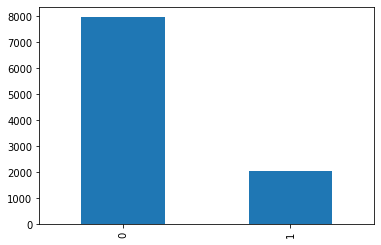

In [49]:
pd.Series(target).value_counts().plot.bar()

In [50]:
target.value_counts()

0    7963
1    2037
Name: exited, dtype: int64

**- создадим список в котом будем фиксировать обозначение модели, f1_score и параметры**

In [51]:
model_comparsion = []

&#9889; **Вывод:** 

1. В датасете сильный дисбаланс классов, что должно плохо сказывается на обучении модели.
2. Соотношение положительных классов к отрицательным - 1 к 4.

[В оглавление](#TOC)

## 2) Построим модели без учета дисбаланса<a class="anchor" id="2_2"></a>

## - DecisionTreeClassifier<a class="anchor" id="2_dtc"></a>

In [52]:
dtc = DecisionTreeClassifier(random_state=42, max_features='auto')

In [53]:
param_grid = {'max_depth': np.arange(10, 20), 'min_samples_leaf': np.arange(1, 20, 2), 'min_samples_split': np.arange(2, 20, 2)}
    
dtc_not_balanced = GridSearchCV(estimator=dtc,
                            param_grid=param_grid,
                            scoring='f1', cv=3,
                            verbose=1, n_jobs=-1)

dtc_not_balanced.fit(x_train, y_train)

best_estimator_dtc_not_balanced = dtc_not_balanced.best_estimator_

Fitting 3 folds for each of 900 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed:    7.6s finished


In [54]:
best_estimator_dtc_not_balanced

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=16,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

### - выведем F1 Score

In [55]:
dtc_not_balanced.score(x_valid, y_valid)

0.42030456852791875

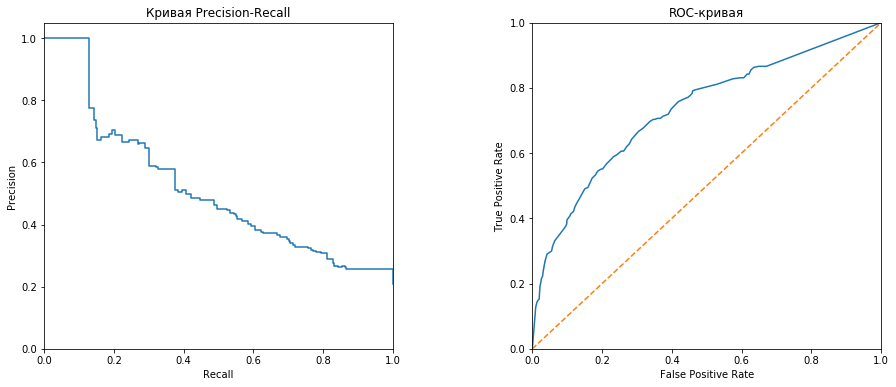

In [56]:
explorer.metrics_plot(dtc_not_balanced, x_valid, y_valid)

### - посчитаем значение ROC-AUC

In [57]:
explorer.auc_roc(dtc_not_balanced, x_valid, y_valid)

0.7323897703497144

### - распечатаем отчет по основным метрикам

In [58]:
print(classification_report(y_valid, dtc_not_balanced.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      2373
           1       0.58      0.33      0.42       627

    accuracy                           0.81      3000
   macro avg       0.71      0.63      0.65      3000
weighted avg       0.79      0.81      0.79      3000



### - выведем матрицу ошибок

In [59]:
pd.DataFrame(confusion_matrix(y_valid, dtc_not_balanced.predict(x_valid)))

,0,1
0,2222,151
1,420,207


### - дополним отчет о результатах и сохраним параметры

In [60]:
model_comparsion.append(('dtc_not_balanced', dtc_not_balanced.score(x_valid, y_valid), best_estimator_dtc_not_balanced))

&#9889; **Вывод:** 

1. Модель показала себя плохо - качество невысокое: F1 Score - 0.42.
2. Модель плохо находит положительный класс (recall) - 0.33.
3. Точнось (precision) модели также невысокая - 0.58.
4. Площадь под кривой (ROC-AUC) - 0.73, лучше случайной модели (0.5), но все же недостаточно хорошо.

[В оглавление](#TOC)

## - RandomForestClassifier<a class="anchor" id="2_rfc"></a>

In [61]:
rfc = RandomForestClassifier(random_state=42, n_estimators=100, max_features='auto', n_jobs=-1)

In [62]:
param_grid = {'max_depth': np.arange(10, 20), 'min_samples_leaf': np.arange(1, 20, 2), 'min_samples_split': np.arange(2, 20, 2)}

rfc_not_balanced = GridSearchCV(estimator=rfc,
                            param_grid=param_grid,
                            scoring='f1', cv=3,
                            verbose=1, n_jobs=-1)

rfc_not_balanced.fit(x_train, y_train)
best_estimator_rfc_not_balanced = rfc_not_balanced.best_estimator_

Fitting 3 folds for each of 900 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed:  2.7min finished


In [63]:
best_estimator_rfc_not_balanced

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=19, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### - выведем F1 Score

In [64]:
rfc_not_balanced.score(x_valid, y_valid)

0.5606694560669456

### - визуализируем PR-кривую и ROC-кривую

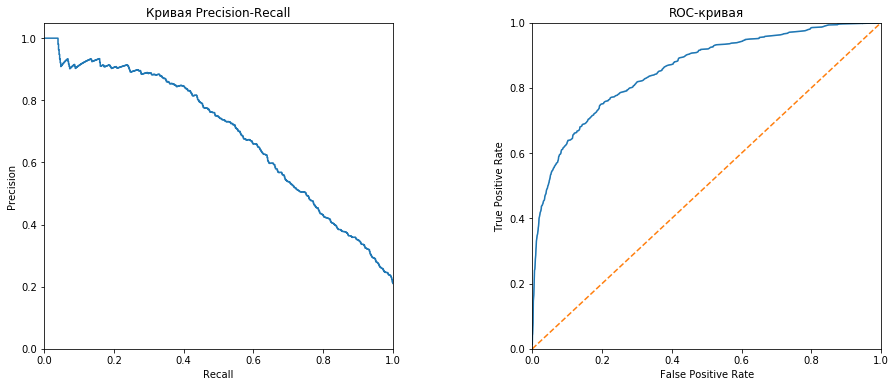

In [65]:
explorer.metrics_plot(rfc_not_balanced, x_valid, y_valid)

### - посчитаем значение ROC-AUC

In [66]:
explorer.auc_roc(rfc_not_balanced, x_valid, y_valid)

0.8547817653546578

### - распечатаем отчет по основным метрикам

In [67]:
print(classification_report(y_valid, rfc_not_balanced.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2373
           1       0.81      0.43      0.56       627

    accuracy                           0.86      3000
   macro avg       0.84      0.70      0.74      3000
weighted avg       0.85      0.86      0.84      3000



### - выведем матрицу ошибок

In [68]:
pd.DataFrame(confusion_matrix(y_valid, rfc_not_balanced.predict(x_valid)))

,0,1
0,2312,61
1,359,268


### - дополним отчет о результатах и сохраним параметры

In [69]:
model_comparsion.append(('rfc_not_balanced', rfc_not_balanced.score(x_valid, y_valid), best_estimator_rfc_not_balanced))

&#9889; **Вывод:** 

1. Модель показала себя плохо, но качество выше, чем у решающего дерева: F1 Score - 0.56.
2. Модель все еще плохо находит положительный класс (recall) - 0.43.
3. Точнось (precision) модели неплохая, доля полжительного класса из определенных моделью - 0.81.
4. Площадь под кривой (ROC-AUC) - 0.86, заметно лучше случайной модели (0.5).

[В оглавление](#TOC)

## Вывод<a class='anchor' id='2_conclusion'>

1. В датасете сильный дисбаланс классов, что плохо сказывается на обучении и результатах модели.
2. Соотношение положительных классов к отрицательным - 1 к 4.
3. Решающее деререво показало F1 Score - 0.42.
4. Случайный лес показал F1 Score - 0.56.

[В оглавление](#TOC)

# 3. Борьба с дисбалансом<a class="anchor" id="3">

## 1) Придадим объектам редкого класса больший вес<a class="anchor" id="3_1">

## - DecisionTreeClassifier<a class="anchor" id="3_dtc">

In [70]:
dtc = DecisionTreeClassifier(random_state=42, class_weight='balanced', max_features='auto')

In [71]:
param_grid = {'max_depth': np.arange(10, 20), 'min_samples_leaf': np.arange(1, 20, 2), 'min_samples_split': np.arange(2, 20, 2)}
    
dtc_c_weighed = GridSearchCV(estimator=dtc,
                            param_grid=param_grid,
                            scoring='f1', cv=3,
                            verbose=1, n_jobs=-1)

dtc_c_weighed.fit(x_train, y_train)

best_estimator_dtc_c_weighed = dtc_c_weighed.best_estimator_

Fitting 3 folds for each of 900 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed:    4.8s finished


In [72]:
best_estimator_dtc_c_weighed

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=10,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

### - выведем F1 Score

In [73]:
dtc_c_weighed.score(x_valid, y_valid)

0.5241730279898219

### - визуализируем PR-кривую и ROC-кривую

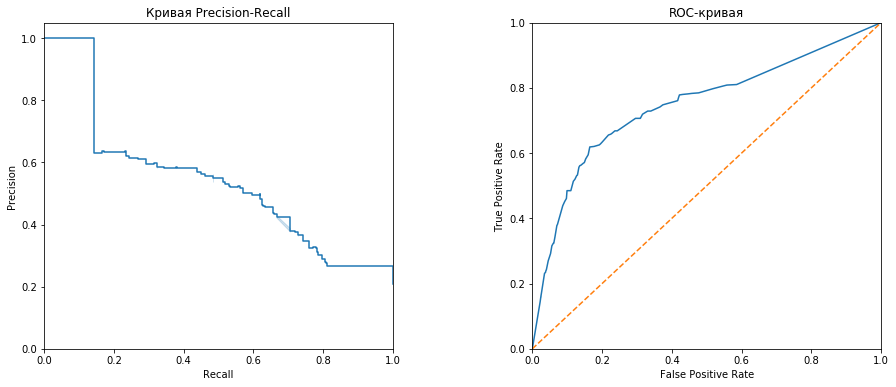

In [74]:
explorer.metrics_plot(dtc_c_weighed, x_valid, y_valid)

### - посчитаем значение ROC-AUC

In [75]:
explorer.auc_roc(dtc_c_weighed, x_valid, y_valid)

0.7467051915118985

### - распечатаем отчет по основным метрикам

In [76]:
print(classification_report(y_valid, dtc_c_weighed.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.90      0.78      0.83      2373
           1       0.44      0.66      0.52       627

    accuracy                           0.75      3000
   macro avg       0.67      0.72      0.68      3000
weighted avg       0.80      0.75      0.77      3000



### - выведем матрицу ошибок

In [77]:
pd.DataFrame(confusion_matrix(y_valid, dtc_c_weighed.predict(x_valid)))

,0,1
0,1840,533
1,215,412


### - дополним отчет о результатах и сохраним параметры

In [78]:
model_comparsion.append(('dtc_c_weighed', dtc_c_weighed.score(x_valid, y_valid), best_estimator_dtc_c_weighed))

&#9889; **Вывод:** 

1. С балансировкой веса класса модель показала себя лучше, качество выросло, хотя и сравнительно осталось низким: F1 Score - 0.52 против 0.43 в первом тесте.
2. Модель заметно лучше находит положительный класс (recall) - 0.66, чем без балансировки (0.58).
3. Доля положительного класса (precision) из определенных моделью - 0.44.
4. Площадь под кривой (ROC-AUC) - 0.75.

[В оглавление](#TOC)

## - RandomForestClassifier<a class="anchor" id="3_rfc">

In [79]:
rfc = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced', max_features='auto', n_jobs=-1)

In [80]:
param_grid = {'max_depth': np.arange(10, 20), 'min_samples_leaf': np.arange(1, 20, 2), 'min_samples_split': np.arange(2, 20, 2)}
    
rfc_c_weighed = GridSearchCV(estimator=rfc,
                            param_grid=param_grid,
                            scoring='f1', cv=3,
                            verbose=1, n_jobs=-1)

rfc_c_weighed.fit(x_train, y_train)

best_estimator_rfc_c_weighed = rfc_c_weighed.best_estimator_

Fitting 3 folds for each of 900 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed:  2.7min finished


In [81]:
best_estimator_rfc_c_weighed

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=18, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=16, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

### - выведем F1 Score

In [82]:
rfc_c_weighed.score(x_valid, y_valid)

0.6282051282051281

### - визуализируем PR-кривую и ROC-кривую

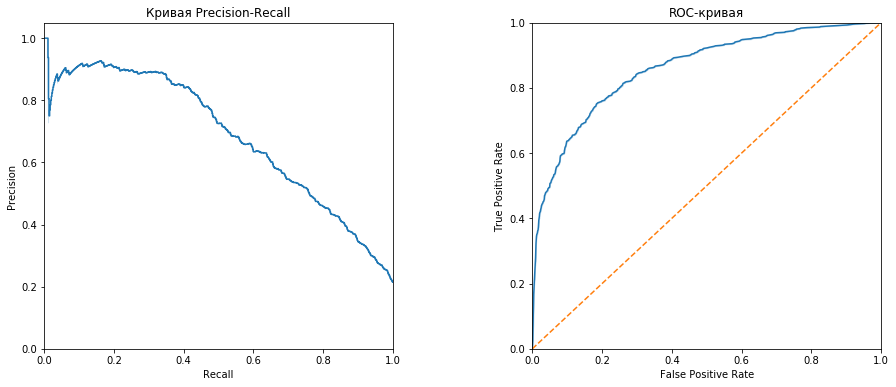

In [83]:
explorer.metrics_plot(rfc_c_weighed, x_valid, y_valid)

### - посчитаем значение ROC-AUC

In [84]:
explorer.auc_roc(rfc_c_weighed, x_valid, y_valid)

0.8594434598160728

### - распечатаем отчет по основным метрикам

In [85]:
print(classification_report(y_valid, rfc_c_weighed.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2373
           1       0.63      0.63      0.63       627

    accuracy                           0.85      3000
   macro avg       0.77      0.76      0.77      3000
weighted avg       0.84      0.85      0.85      3000



### - выведем матрицу ошибок

In [86]:
pd.DataFrame(confusion_matrix(y_valid, rfc_c_weighed.predict(x_valid)))

,0,1
0,2144,229
1,235,392


### - дополним отчет о результатах и сохраним параметры

In [87]:
model_comparsion.append(('rfc_c_weighed', rfc_c_weighed.score(x_valid, y_valid), best_estimator_rfc_c_weighed))

&#9889; **Вывод:** 

1. Заметный рост качества при балансировки весов классов: F1 Score - 0.63 против 0.56 без балансировки.
2. Модель заметно лучше находит положительный класс (recall) - 0.63, чем без балансировки (0.43).
3. При росте полноты снизилась точность (precision) - 0.63 проти 0.81 без балансировки.
4. Площадь под кривой осталась неизменной по сравнению с моделью без балансировки (ROC-AUC) - 0.86.

[В оглавление](#TOC)

## 2) Увеличение выборки<a class="anchor" id="3_2"></a>

Продублируем объекты положительного класса и объедините их с объектами отрицательного класса

In [88]:
features_upsampled, target_upsampled = explorer.upsample(x_train, y_train, 4)

## - DecisionTreeClassifier<a class="anchor" id="3_2_dtc">

In [89]:
dtc = DecisionTreeClassifier(random_state=42, max_features='auto')

In [90]:
param_grid = {'max_depth': np.arange(1, 20), 'min_samples_leaf': np.arange(1, 20, 2), 'min_samples_split': np.arange(2, 20, 2)}
    
dtc_upsampled = GridSearchCV(estimator=dtc,
                            param_grid=param_grid,
                            scoring='f1', cv=3,
                            verbose=1, n_jobs=-1)

dtc_upsampled.fit(features_upsampled, target_upsampled)

best_estimator_dtc_upsampled = dtc_upsampled.best_estimator_

Fitting 3 folds for each of 1710 candidates, totalling 5130 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 5130 out of 5130 | elapsed:    9.2s finished


In [91]:
best_estimator_dtc_upsampled

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=19,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

### - выведем F1 Score

In [92]:
dtc_upsampled.score(x_valid, y_valid)

0.45020920502092043

### - визуализируем PR-кривую и ROC-кривую

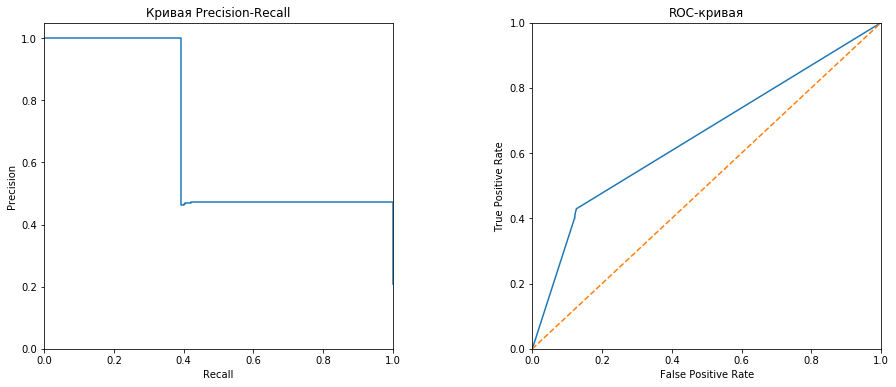

In [93]:
explorer.metrics_plot(dtc_upsampled, x_valid, y_valid)

### - посчитаем значение ROC-AUC

In [94]:
explorer.auc_roc(dtc_upsampled, x_valid, y_valid)

0.6503251962031654

### - распечатаем отчет по основным метрикам

In [95]:
print(classification_report(y_valid, dtc_upsampled.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      2373
           1       0.47      0.43      0.45       627

    accuracy                           0.78      3000
   macro avg       0.66      0.65      0.66      3000
weighted avg       0.77      0.78      0.78      3000



### - выведем матрицу ошибок

In [96]:
pd.DataFrame(confusion_matrix(y_valid, dtc_upsampled.predict(x_valid)))

,0,1
0,2074,299
1,358,269


### - дополним отчет о результатах и сохраним параметры

In [97]:
model_comparsion.append(('dtc_upsampled', dtc_upsampled.score(x_valid, y_valid), best_estimator_dtc_upsampled))

&#9889; **Вывод:** 

1. Увеличение выборки плохо сказалось на модели: F1 Score - 0.45.
2. Модель заметно плохо находит положительный класс (recall) - 0.43.
3. У модели низкая точность (precision) - 0.47.
4. Площадь под кривой (ROC-AUC) - 0.65.
5. Увеличение выборки сильно ухудшило результат.

[В оглавление](#TOC)

## - RandomForestClassifier<a class="anchor" id="3_2_rfc">

In [98]:
rfc = RandomForestClassifier(random_state=42, n_estimators=100, max_features='auto', n_jobs=-1)

In [99]:
param_grid = {'max_depth': np.arange(10, 20), 'min_samples_leaf': np.arange(1, 20, 2), 'min_samples_split': np.arange(2, 20, 2)}
    
rfc_upsampled = GridSearchCV(estimator=rfc,
                            param_grid=param_grid,
                            scoring='f1', cv=3,
                            verbose=1, n_jobs=-1)

rfc_upsampled.fit(features_upsampled, target_upsampled)
best_estimator_rfc_upsampled = rfc_upsampled.best_estimator_

Fitting 3 folds for each of 900 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed:  3.6min finished


In [100]:
best_estimator_rfc_upsampled

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=17, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### - выведем F1 Score

In [101]:
rfc_upsampled.score(x_valid, y_valid)

0.5888689407540395

### - визуализируем PR-кривую и ROC-кривую

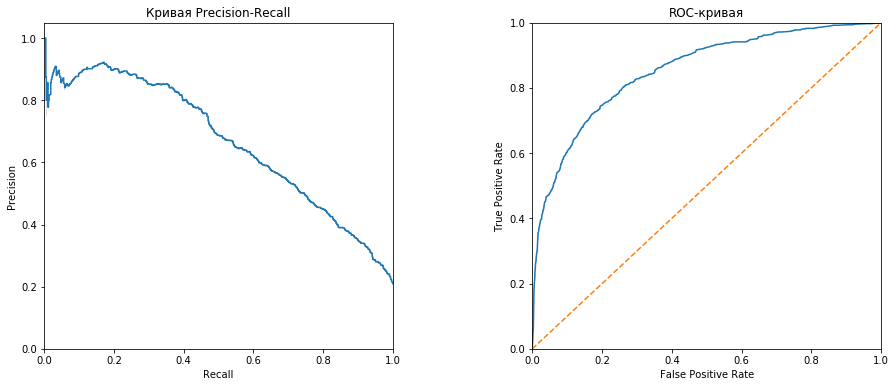

In [102]:
explorer.metrics_plot(rfc_upsampled, x_valid, y_valid)

### - посчитаем значение ROC-AUC

In [103]:
explorer.auc_roc(rfc_upsampled, x_valid, y_valid)

0.852991959652416

### - распечатаем основные отчет по основным метрикам

In [104]:
print(classification_report(y_valid, rfc_upsampled.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91      2373
           1       0.67      0.52      0.59       627

    accuracy                           0.85      3000
   macro avg       0.78      0.73      0.75      3000
weighted avg       0.84      0.85      0.84      3000



### - выведем матрицу ошибок

In [105]:
pd.DataFrame(confusion_matrix(y_valid, rfc_upsampled.predict(x_valid)))

,0,1
0,2214,159
1,299,328


### - дополним отчет о результатах и сохраним параметры

In [106]:
model_comparsion.append(('rfc_upsampled', rfc_upsampled.score(x_valid, y_valid), best_estimator_rfc_upsampled))

&#9889; **Вывод:** 

1. Модель случайного леса, обученная на увеличенной выборке, показала на валидационной выборке F1 Score - 0.59.
2. Значение полноты (recall) - 0.52.
3. Зато точность (precision) - 0.67.
4. Площадь под кривой (ROC-AUC) - 0.85.
5. Результат хуже чем, у модели со взешенными классами.

[В оглавление](#TOC)

## 3) Уменьшение выборки<a class="anchor" id="3_3"></a>

Исключим объекты отрицательного класса и объединим их с объектами положительного класса

In [107]:
features_downsampled, target_downsampled = explorer.downsample(x_train, y_train, 0.5)

## - DecisionTreeClassifier<a class="anchor" id="3_3_dtc">

In [108]:
dtc = DecisionTreeClassifier(random_state=42, max_features='auto')

In [109]:
param_grid = {'max_depth': np.arange(1, 20), 'min_samples_leaf': np.arange(1, 20, 2), 'min_samples_split': np.arange(2, 20, 2)}
    
dtc_downsampled = GridSearchCV(estimator=dtc,
                            param_grid=param_grid,
                            scoring='f1', cv=3,
                            verbose=1, n_jobs=-1)

dtc_downsampled.fit(features_downsampled, target_downsampled)

best_estimator_dtc_downsampled = dtc_downsampled.best_estimator_

Fitting 3 folds for each of 1710 candidates, totalling 5130 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 5130 out of 5130 | elapsed:    6.3s finished


In [110]:
best_estimator_dtc_downsampled

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

### - выведем F1 Score

In [111]:
dtc_downsampled.score(x_valid, y_valid)

0.5207373271889401

### - визуализируем PR-кривую и ROC-кривую

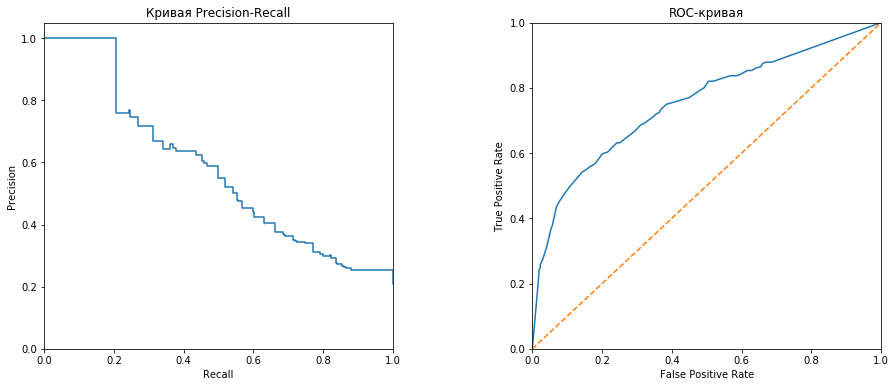

In [112]:
explorer.metrics_plot(dtc_downsampled, x_valid, y_valid)

### - посчитаем значение ROC-AUC

In [113]:
explorer.auc_roc(dtc_downsampled, x_valid, y_valid)

0.7519569908950441

### - распечатаем основные отчет по основным метрикам

In [114]:
print(classification_report(y_valid, dtc_downsampled.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      2373
           1       0.50      0.54      0.52       627

    accuracy                           0.79      3000
   macro avg       0.69      0.70      0.69      3000
weighted avg       0.80      0.79      0.79      3000



### - выведем матрицу ошибок

In [115]:
pd.DataFrame(confusion_matrix(y_valid, dtc_downsampled.predict(x_valid)))

,0,1
0,2037,336
1,288,339


### - дополним отчет о результатах и сохраним параметры

In [116]:
model_comparsion.append(('dtc_downsampled', dtc_downsampled.score(x_valid, y_valid), best_estimator_dtc_downsampled))

&#9889; **Вывод:** 

1. Модель решающего дерева, обученная на уменьшенной выборке, показала на валидационной выборке F1 Score - 0.52.
2. Значение полноты (recall) - 0.54.
3. Зато точность (precision) - 0.50.
4. Площадь под кривой (ROC-AUC) - 0.75.
5. Результат близок к модели решающего дерева со взешенными классами.

[В оглавление](#TOC)

## - RandomForestClassifier<a class="anchor" id="3_3_rfc">

In [117]:
rfc = RandomForestClassifier(random_state=42, n_estimators=100, max_features='auto', n_jobs=-1)

In [118]:
param_grid = {'max_depth': np.arange(10, 20), 'min_samples_leaf': np.arange(1, 20, 2), 'min_samples_split': np.arange(2, 20, 2)}
    
rfc_downsampled = GridSearchCV(estimator=rfc,
                            param_grid=param_grid,
                            scoring='f1', cv=3,
                            verbose=1, n_jobs=-1)

rfc_downsampled.fit(features_downsampled, target_downsampled)
best_estimator_rfc_downsampled = rfc_downsampled.best_estimator_

Fitting 3 folds for each of 900 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed:  2.2min finished


In [119]:
best_estimator_rfc_downsampled

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=17, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### - выведем F1 Score

In [120]:
rfc_downsampled.score(x_valid, y_valid)

0.630091438071488

### - визуализируем PR-кривую и ROC-кривую

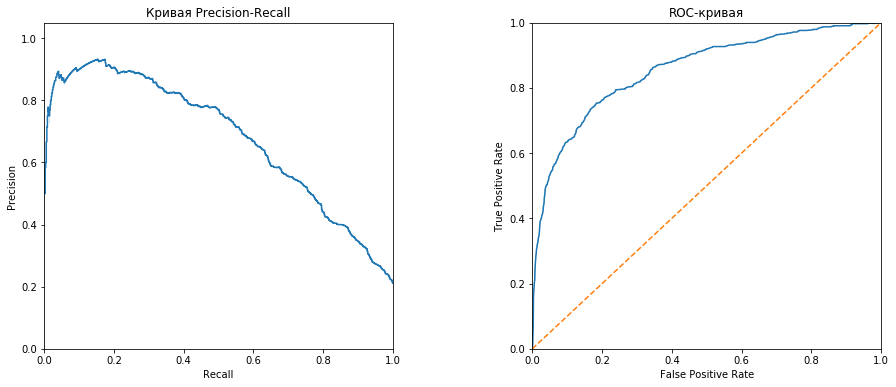

In [121]:
explorer.metrics_plot(rfc_downsampled, x_valid, y_valid)

### - посчитаем значение ROC-AUC

In [122]:
explorer.auc_roc(rfc_downsampled, x_valid, y_valid)

0.8557028801556049

### - распечатаем основные отчет по основным метрикам

In [123]:
print(classification_report(y_valid, rfc_downsampled.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2373
           1       0.66      0.60      0.63       627

    accuracy                           0.85      3000
   macro avg       0.78      0.76      0.77      3000
weighted avg       0.85      0.85      0.85      3000



### - выведем матрицу ошибок

In [124]:
pd.DataFrame(confusion_matrix(y_valid, rfc_downsampled.predict(x_valid)))

,0,1
0,2176,197
1,248,379


### - дополним отчет о результатах и сохраним параметры

In [125]:
model_comparsion.append(('rfc_downsampled', rfc_downsampled.score(x_valid, y_valid), best_estimator_rfc_downsampled))

&#9889; **Вывод:** 

1. Модель случайного леса, обученная на уменьшенной выборке, показала на валидационной выборке F1 Score - 0.63.
2. Значение полноты (recall) - 0.60.
3. Зато точность (precision) - 0.66.
4. Площадь под кривой (ROC-AUC) - 0.86.
5. Результат близок к модели случайного леса со взвешенными классами.

[В оглавление](#TOC)

## 4) Увеличим выборку с помощью алгоритма SMOTE (Synthetic Minority Over-sampling Technique)<a class="anchor" id="3_4"></a>

Методика SMOTE (методика синтетического пересчета меньшинств): алгоритм генерирует некоторое количества искусственных примеров меньшинства на основе k-близжайших соседей. Таким образом, в датасет добавляют искусственные наблюдения похожие на искомый клас, но не дублирующие его.

### - передадим тренировочные данные алгоритму (инициализирован ранее)

In [126]:
x_train_smote, y_train_smote = sm.fit_sample(x_train, y_train.ravel())

### - проверим баланс классов после увеличения выборки

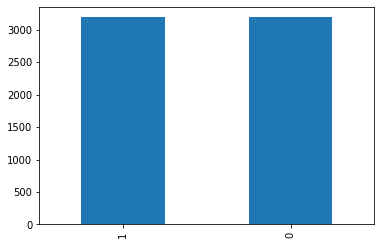

In [127]:
pd.Series(y_train_smote).value_counts().plot.bar()

&#9889; **Вывод:** в результате работы обработки методикой SMOTE балансы классов сведены 1 к 1

[В оглавление](#TOC)

## - DecisionTreeClassifier<a class="anchor" id="3_4_dtc">

In [128]:
dtc = DecisionTreeClassifier(random_state=42, max_features='auto')

In [129]:
param_grid = {'max_depth': np.arange(1, 20), 'min_samples_leaf': np.arange(1, 20, 2), 'min_samples_split': np.arange(2, 20, 2)}
    
dtc_smote = GridSearchCV(estimator=dtc,
                            param_grid=param_grid,
                            scoring='f1', cv=3,
                            verbose=1, n_jobs=-1)

dtc_smote.fit(x_train_smote, y_train_smote)

best_estimator_dtc_smote = dtc_smote.best_estimator_

Fitting 3 folds for each of 1710 candidates, totalling 5130 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 5130 out of 5130 | elapsed:    6.0s finished


In [130]:
best_estimator_dtc_smote

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=14,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

### - выведем F1 Score

In [131]:
dtc_smote.score(x_valid, y_valid)

0.4498736310025274

### - визуализируем PR-кривую и ROC-кривую

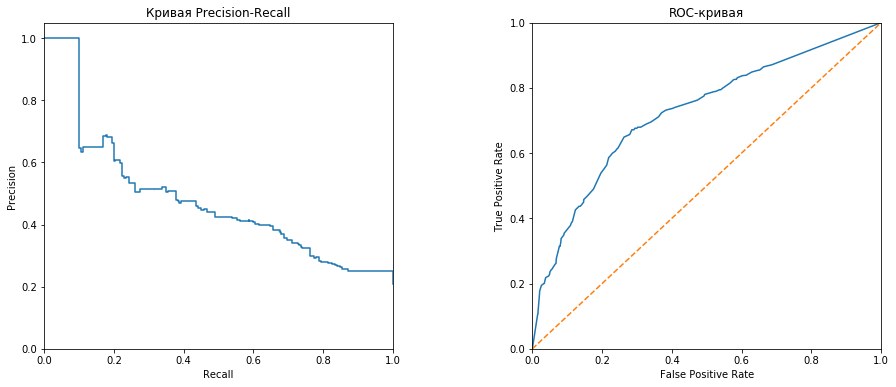

In [132]:
explorer.metrics_plot(dtc_smote, x_valid, y_valid)

### - посчитаем значение ROC-AUC

In [133]:
explorer.auc_roc(dtc_smote, x_valid, y_valid)

0.7241010813437454

### - распечатаем основные отчет по основным метрикам

In [134]:
print(classification_report(y_valid, dtc_smote.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      2373
           1       0.48      0.43      0.45       627

    accuracy                           0.78      3000
   macro avg       0.66      0.65      0.66      3000
weighted avg       0.77      0.78      0.78      3000



### - выведем матрицу ошибок

In [135]:
pd.DataFrame(confusion_matrix(y_valid, dtc_smote.predict(x_valid)))

,0,1
0,2080,293
1,360,267


### - дополним отчет о результатах и сохраним параметры

In [136]:
model_comparsion.append(('dtc_smote', dtc_smote.score(x_valid, y_valid), best_estimator_dtc_smote))

&#9889; **Вывод:** 

1. Модель решающего дерева, обученная на выборке сбалансированной с помощью SMOTE, показала результат практически идентичный модели, обученной с помощью кратного повторения значений класса: F1 Score - 0.45.
2. Модель заметно плохо находит положительный класс (recall) - 0.43.
3. У модели низкая точность (precision) - 0.48.
4. Площадь под кривой (ROC-AUC) - 0.72.

[В оглавление](#TOC)

## - RandomForestClassifier<a class="anchor" id="3_4_rfc">

In [137]:
rfc = RandomForestClassifier(random_state=42, n_estimators=100, max_features='auto', n_jobs=-1)

In [138]:
param_grid = {'max_depth': np.arange(10, 20), 'min_samples_leaf': np.arange(1, 20, 2), 'min_samples_split': np.arange(2, 20, 2)}
    
rfc_smote = GridSearchCV(estimator=rfc,
                            param_grid=param_grid,
                            scoring='f1', cv=3,
                            verbose=1, n_jobs=-1)

rfc_smote.fit(x_train_smote, y_train_smote)
best_estimator_rfc_smote = rfc_smote.best_estimator_

Fitting 3 folds for each of 900 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed:  3.9min finished


In [139]:
best_estimator_rfc_smote

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### - выведем F1 Score

In [140]:
rfc_smote.score(x_valid, y_valid)

0.6042632066728453

### - визуализируем PR-кривую и ROC-кривую

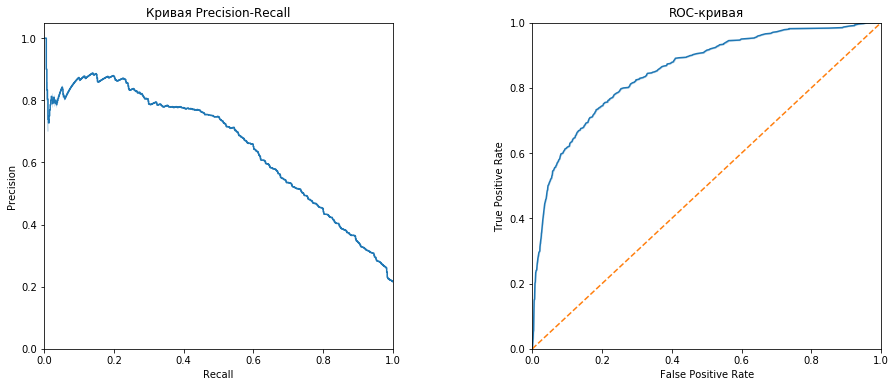

In [141]:
explorer.metrics_plot(rfc_smote, x_valid, y_valid)

### - посчитаем значение ROC-AUC

In [142]:
explorer.auc_roc(rfc_smote, x_valid, y_valid)

0.853108905274718

### - распечатаем основные отчет по основным метрикам

In [143]:
print(classification_report(y_valid, rfc_smote.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      2373
           1       0.72      0.52      0.60       627

    accuracy                           0.86      3000
   macro avg       0.80      0.73      0.76      3000
weighted avg       0.85      0.86      0.85      3000



### - выведем матрицу ошибок

In [144]:
pd.DataFrame(confusion_matrix(y_valid, rfc_smote.predict(x_valid)))

,0,1
0,2247,126
1,301,326


### - дополним отчет о результатах и сохраним параметры

In [145]:
model_comparsion.append(('rfc_smote', rfc_smote.score(x_valid, y_valid), best_estimator_rfc_smote))

&#9889; **Вывод:** 

1. Модель случайного леса, обученная на уменьшенной выборке, показала на валидационной выборке F1 Score - 0.60.
2. Значение полноты (recall) - 0.52.
3. Зато точность (precision) - 0.72.
4. Площадь под кривой (ROC-AUC) - 0.85.
5. Результат близок к модели случайного леса со взешенными классами и модели, обученной на выборке с кратным увеличением классов.

[В оглавление](#TOC)

## 5) Выведем таблицу построенных моделей с результатами F1 Score выше 0.59 на валидационных данных. <a class="anchor" id="3_5"></a>

In [146]:
model_comparsion_df = pd.DataFrame(model_comparsion, columns=['model', 'f1_score_valid', 'params'])

In [147]:
best_models_train_valid = model_comparsion_df[['model', 'f1_score_valid']].sort_values(by='f1_score_valid', ascending=False)
best_models_train_valid.query('f1_score_valid > 0.59').style.highlight_max(color='lightgreen', axis = 0)

,model,f1_score_valid
7,rfc_downsampled,0.630091
3,rfc_c_weighed,0.628205
9,rfc_smote,0.604263


&#9889; **Вывод:** 
1. Лучший F1 Score на валидационных данных у модели RandomForestClassifier, обученной на выборке с уменьшенным количеством отрицательных классов: rfc_downsampled - 0.63.
2. Результат F1 Score выше 0.59 показало еще две модели RandomForestClassifier:
    - обученная с взвешенными классами: rfc_c_weighed - 0.63,
    - обученная на выборке со сбалансированными алгоритмом SMOTE классами: rfc_smote - 0.6.

[В оглавление](#TOC)

## Вывод<a class='anchor' id='3_conclusion'>

1. Устранение дисбаланса в целом положительно повлияло на результаты моделей.
2. F1 Score на валидационных данных после устранения дисбаланса выше 0.59 показали три модели RandomForestClassifier:
    - с уменьшенным количеством отрицательных классов - 0.63,
    - с взвешенными классами - 0.63,
    - обученная на выборке со сбалансированными алгоритмом SMOTE классами - 0.6.

[В оглавление](#TOC)

# 4. Тестирование модели<a class="anchor" id="4"></a>

## 1) Посчитаем для каждой из моделей F1 Score на тестовых данных и дополним таблицу<a class='anchor' id='4_1'>

In [148]:
model_comparsion_df['f1_score_test'] = model_comparsion_df['params'].apply(lambda model: f1_score(y_test, model.predict(x_test)))

### - выведем модели с результатом F1 Score на тестовой выборке выше 0.59

In [149]:
best_models_train_test = model_comparsion_df[['model', 'f1_score_test']].sort_values(by='f1_score_test', ascending=False)
best_models_train_test.query('f1_score_test > 0.59').style.highlight_max(color='lightgreen', axis = 0)

,model,f1_score_test
3,rfc_c_weighed,0.621149
7,rfc_downsampled,0.606164
5,rfc_upsampled,0.595149


&#9889; **Вывод:** 
1. Лучший F1 Score на тестовых данных у модели RandomForestClassifier со взвешенными классами: rfc_c_weighed - 0.62.
2. Результат F1 Score выше 0.59 показало еще две модели RandomForestClassifier:
    - с уменьшенным количеством отрицательных классов: rfc_downsampled - 0.61
    - обученная на выборке увеличенным количеством положительных классов: rfc_upsampled - 0.6.

[В оглавление](#TOC)

## 2) Рассмотрим подробнее модель с лучшим F1 Score на тестовых данных<a class='anchor' id='4_2'>

Лучший результат показала модель RandomForestClassifier со взвешенными классами: F1 Score - 0.62

### - визуализируем PR-кривую и ROC-кривую

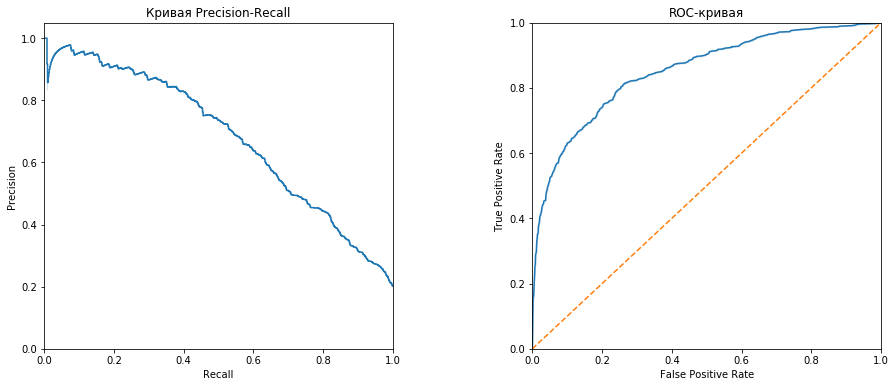

In [150]:
explorer.metrics_plot(rfc_c_weighed, x_test, y_test)

### - посчитаем значение ROC-AUC

In [151]:
explorer.auc_roc(rfc_c_weighed, x_test, y_test)

0.8514706401243677

### - распечатаем основные отчет по основным метрикам

In [152]:
print(classification_report(y_test, rfc_c_weighed.predict(x_test)))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      2397
           1       0.62      0.62      0.62       603

    accuracy                           0.85      3000
   macro avg       0.76      0.76      0.76      3000
weighted avg       0.85      0.85      0.85      3000



### - выведем матрицу ошибок

In [153]:
pd.DataFrame(confusion_matrix(y_test, rfc_c_weighed.predict(x_test)))

,0,1
0,2172,225
1,230,373


&#9889; **Вывод:** 

1. F1 Score модели - 0.62, выше целевого показателя в 0.59.
2. Значение полноты (recall) - 0.62.
3. Точность (precision) - 0.62.
4. Площадь под кривой (ROC-AUC) - 0.85, результат далек от единицы, но лучше, чем у случайной модели.
5. В целом, качество модели не очень высокое.

[В оглавление](#TOC)

## Вывод<a class='anchor' id='4_conclusion'>

1. Дисбаланс в датасете сильно влиял на качество модели.
2. Увеличение выборки, уменьшение выборки и взвешевание классов как средство борьбы с дисбалансом для RandomForestClassifier показали себя хорошо.
3. Три лучших модели показали на тестовой выборке результат F1 Score выше 0.59:
    - RandomForestClassifier со взвешенными классами - 0.62,
    - RandomForestClassifier с уменьшенным количеством отрицательных классов - 0.61,
    - RandomForestClassifier обученная на выборке увеличенным количеством положительных классов - 0.6.
4. Результаты модели умеренные, но это, вероятно, связано с признаками, значения которых в наблюдениях обоих классах близки к друг другу.
5. Если исходить из метрики ROC-AUC - 0.85 на лучшей модели - то предсказания модели заметно выше случайной.

[В оглавление](#TOC)